In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

In [2]:
#we first load the npz files as numpy arrays to understand the format of the data
import os

with np.load(os.path.join('data', 'QG_jets_1.npz')) as data:
    design_matrix = data['X']
    labels = data['y']

In [3]:
#we are given 3-d arrays wherein each 2d array comprises of the particles in the wave
#these are described by the 4 properties listed 
#p_T = transverse momentum
#rapidity = angle and velocity of particle
#azimuthal angle = angle in transverse plane
#pdg id = used to identify the type of particle
#and the data has been padded to maintain uniformity
#for labels 0 -> gluon and 1 -> quark

#the over all approach here will be to extract features on the basis of which we can differentiate
#the 2 classes and build a dataset corresponding of those features
print(design_matrix[0][:10])
print(labels[0])

[[ 6.21580243e-01 -8.49013586e-01  5.02133119e+00 -2.11000000e+02]
 [ 6.41751806e-01 -1.25072426e+00  5.44050034e+00  2.11000000e+02]
 [ 2.01318448e-01 -9.03872384e-01  4.90318847e+00  2.20000000e+01]
 [ 2.12267880e-01 -1.53007561e+00  5.25772266e+00 -2.11000000e+02]
 [ 1.15715993e-01 -1.21637938e+00  4.72293956e+00  2.20000000e+01]
 [ 1.74847256e+00 -9.77056889e-01  5.22212920e+00  2.20000000e+01]
 [ 1.62771810e+01 -1.04474590e+00  5.24203347e+00  1.30000000e+02]
 [ 4.66200635e-01 -9.77083045e-01  5.04801498e+00 -3.21000000e+02]
 [ 1.76574942e+00 -1.41171296e+00  5.27212383e+00  2.20000000e+01]
 [ 1.60427641e+01 -1.02307416e+00  5.18584440e+00  1.30000000e+02]]
0.0


In [4]:
#we define a function to get number of particles in the jet stream
#aka to get the multiplicity
def find_multiplicity(jet_stream):
    mul = 0
    for particle in jet_stream:
        if particle[3] != 0:
            mul += 1
    return mul

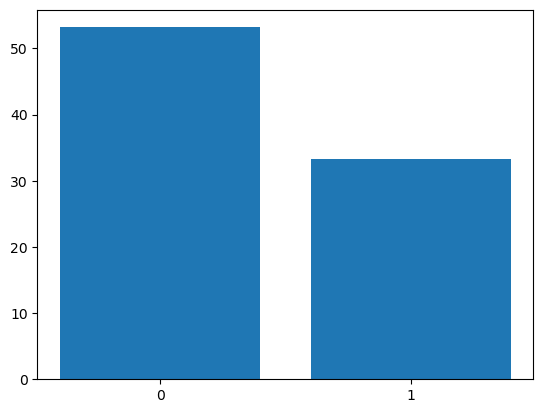

In [5]:
#we plot a comparison bar graph of the average particles per stream
#we can evidently see a stark difference between the 2 -> multiplicity of jet streams is an important
#factor towards differentiating the two (gluon jets have higher number of particles than quark jets)
avg_mul = {0:0, 1:0}
for i, stream in enumerate(design_matrix):
    particles = find_multiplicity(stream)
    avg_mul[labels[i]]+=particles

avg_mul[0] /= 50000
avg_mul[1] /=50000

plt.bar(range(len(avg_mul)), list(avg_mul.values()), align='center')
plt.xticks(range(len(avg_mul)), list(avg_mul.keys()))
plt.show()

In [6]:
#The pdg_id helps identify each particle, it might be helpful to explore what all particles
#and in what frequency are present in quark and gluon jets

#I have made a dictionary with each particle and its count in a given jet class
particles = [{}, {}]

for i, stream in enumerate(design_matrix):
    for particle in stream:
        if particle[3]==0:
            continue
        if particle[3] in particles[int(labels[i])].keys():
            particles[int(labels[i])][particle[3]] += 1
        else:
            particles[int(labels[i])][particle[3]] = 1


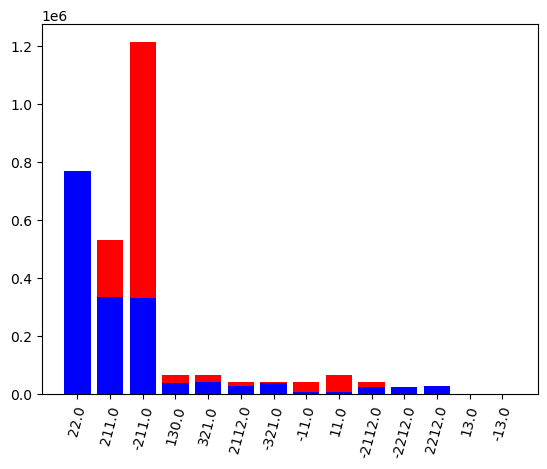

In [22]:
#since the number of particles is the same for both quark and gluon jets
#the average number of particles of each type will plot very similar to that
#of the number of particles of each type in each jet stream thus to reduce computation
#we just compare net particles
plt.bar(range(len(particles[0])), list(particles[0].values()), color='red')
plt.xticks(range(len(particles[0])), list(particles[0].keys()), rotation=75)

plt.bar(range(len(particles[1])), list(particles[1].values()), color='blue')
plt.xticks(range(len(particles[1])), list(particles[1].keys()), rotation = 75)

plt.show()

#we can see that both the classes consist of different types of particles to a large extent
#this can be useful for classifying them
#notably class 0 has an abundance of PDG ID -> -211 ans class 1 -> 22.0 other particles also play a role

In [8]:
#we attempt to viualise the spread in azimuthal angle, this can be visualised
#via the standard deviation wrt the mean, higher the standard deviation the more
#spread out the angules are the higher its standard deviation will be

def std_dev(stream):
    azimuth = []
    for particle in stream:
        if particle[3]!=0:
            azimuth.append(particle[2])

    return np.std(azimuth)

std_dev_list = [[], []]
for i, stream in enumerate(design_matrix):
    std_dev_list[int(labels[i])].append(std_dev(stream))

(array([[6.0000e+00, 1.4700e+02, 2.1610e+03, 1.1707e+04, 1.9977e+04,
         1.1782e+04, 3.3480e+03, 7.1800e+02, 1.3500e+02, 1.9000e+01],
        [9.4000e+01, 1.1610e+03, 5.2150e+03, 1.3628e+04, 1.6743e+04,
         9.5460e+03, 3.0020e+03, 5.4600e+02, 5.6000e+01, 9.0000e+00]]),
 array([0.00179817, 0.02673558, 0.05167298, 0.07661039, 0.10154779,
        0.1264852 , 0.1514226 , 0.17636   , 0.20129741, 0.22623481,
        0.25117222]),
 <a list of 2 BarContainer objects>)

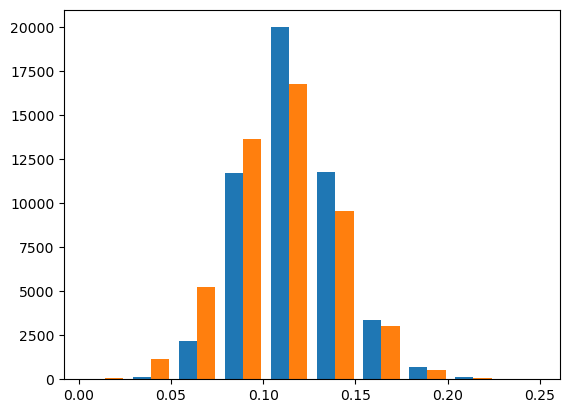

In [9]:
#we can see from the histogram that gluon jets (class 0) have more particles in the
#higher standard deviation range compared to quark jets (class 1)

#important point to note here is between std dev of 0-0.1 we see more number of quark jet
#particles compared to gluon jets, which means a gluon jet particle is more likely to have
#a higher standard deviation compared to quark jets

#we can also infer that gluon jets are more spread out compared to quark jets since 
#the particles deviate more in case of gluon jets

plt.hist(std_dev_list)

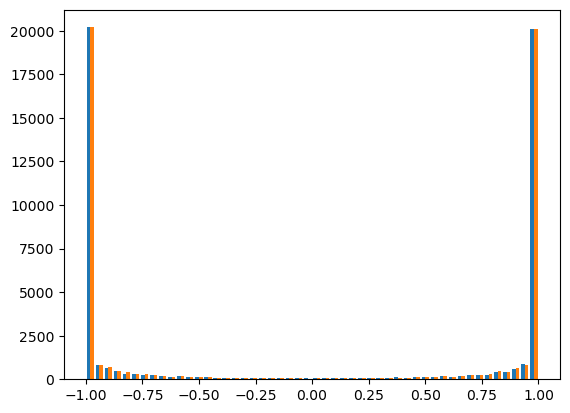

In [18]:
#forward/backward asymmetry is a metric to determine and account for how much of a bias do we have
#in the forward or backward direction

def fb_as(stream):
    n_f = 0
    n_b = 0
    for particle in stream:
        if(particle[3]!=0):
            if particle[1] > 0:
                n_f+=1
            else:
                n_b+=1
    return (n_f-n_b)/(n_f+n_b)

asymmetries = [[], []]
for i, stream in enumerate(design_matrix):
    asymmetries[int(labels[i])].append(fb_as(stream))

plt.hist(asymmetries, bins=50)
plt.show()
#we see a very symettric distribution for both classses hence we abandon this as a potential differentiating factor

In [11]:
def mean(i, stream):
    sum_=0
    count=0
    for particle in stream:
        if particle[3] != 0:
            sum_ += particle[i]
            count += 1
    return sum_/count

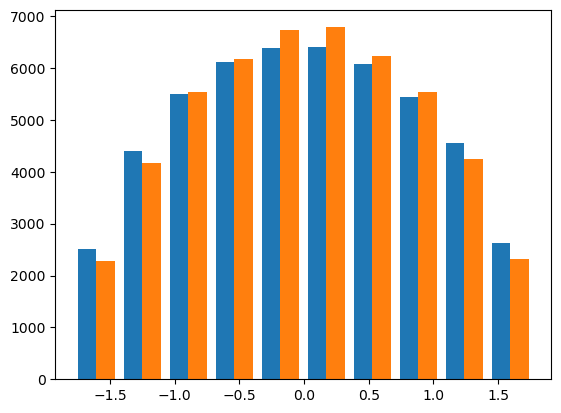

In [12]:
#a plot of the average rapidity per stream shows that quarks tend to have a higher rapidity
#value compared to gluons, we also see that gluons have a more spread out rapidity profile
#as compared to quark jets which are centered about 0.0 more

rapidities = [[], []]

for i, stream in enumerate(design_matrix):
    rapidities[int(labels[i])].append(mean(1, stream))

plt.hist(rapidities)
plt.show()

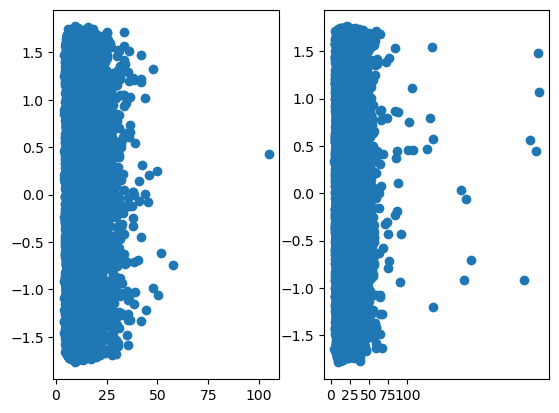

In [30]:
#we plot a scatter plot to compare between rapidity and transverse momentum 
#we observe for both particles the rapidity is spread out similarly
#as inferred from above however the transverse momentum of quark particles
#is higher than gluon particles
plt.subplot(1,2,1)
plt.scatter(p_t[0], rapidities[0])

plt.subplot(1,2,2)
plt.scatter(p_t[1], rapidities[1])
plt.xticks(np.arange(0,101, step=25))

plt.show()

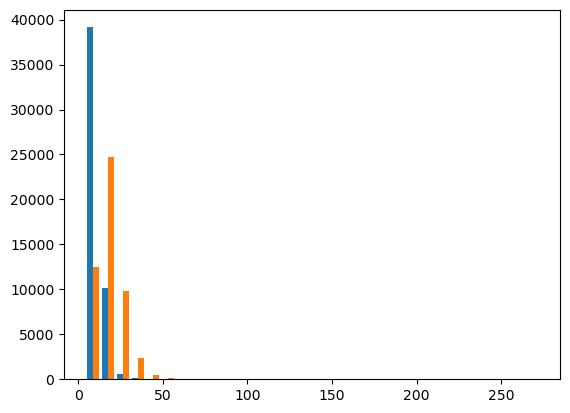

In [14]:
#finally we study transverse momentum, first we simply try to compare the average values
#we can see that gluons have less p_t compared to quark jets which have alot of particles 
#with a larger transverse momentum as verified from above

p_t = [[], []]

for i, stream in enumerate(design_matrix):
    p_t[int(labels[i])].append(mean(0, stream))

plt.hist(p_t, bins=30)
plt.show()

In [15]:
#this is a function which returns a DataFrame object containing the extracted features from each jet stream
#this is the dataset we will use for training

def process_dataframe(design_matrix):      
    data_frame = []

    id_particles = {}
    for i, j in zip(particles[0].keys(), particles[1].keys()):
        if i not in id_particles.keys():
            id_particles[i] = 0
        if j not in id_particles.keys():
            id_particles[i] = 0
            

        
    for i, stream in enumerate(design_matrix):
        multiplicity = 0
        for i in id_particles.keys():
            id_particles[i]=0
        for particle in stream:
            if particle[3]!=0:
                id_particles[particle[3]] += 1
                multiplicity += 1
        data_frame.append([multiplicity, std_dev(stream), mean(1, stream), mean(0, stream)] + [i for i in id_particles.values()])
        
    return pd.DataFrame(data_frame)

In [16]:
#creating the dataframe object
df = process_dataframe(design_matrix)

In [140]:
#we use cross validation to verify our model, I have used Random Forest Classifier
#since it fits well with non linear data and resists overfitting

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier()

np.mean(cross_val_score(clf, df, labels, cv=10, scoring = 'accuracy'))

0.775


In [ ]:
'''
In summary, we extracted features from the jet stream which can be used as metrics to differentiate
between quark and gluon jets, and trained a classifier for the same
'''